In [1]:
import numpy as np
import pandas as pd
from glob import glob
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, DenseNet121, InceptionV3
from keras.utils import np_utils
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
!sudo chown -R ds:ds /data

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path, n_classes):
    """Returns the path and the Label from the folder"""
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), n_classes)
    return chest_files, chest_targets

# load list of dog names
labels = [item[18:-1] for item in sorted(glob("../imgs/all/train/*/"))]
n_classes = len(labels)

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../imgs/all/train', n_classes)
test_files, test_targets = load_dataset('../imgs/all/test', n_classes)

# Img size
img_width, img_height, channels = 224, 224, 3

#proportions
train_prop = np.count_nonzero(train_targets, axis=0) / len(train_targets)
test_prop = np.count_nonzero(test_targets, axis=0) / len(test_targets)

print('Proportions: \n')
for index, label in enumerate(labels):
    print('{} train: {:.4f}'.format(label, train_prop[index]*100))
    print('{} test: {:.4f}'.format(label, test_prop[index]*100))
    print('*********************')

print('\nStatistics about the Dataset:\n')
print('There are %d total chest deseases.' % len(labels))
print('There are %s total chest images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training chest images.' % len(train_files))
print('There are %d test chest images.'% len(test_files))

Proportions: 

Atelectasis train: 15.9895
Atelectasis test: 10.6340
*********************
Cardiomegaly train: 4.0766
Cardiomegaly test: 7.8382
*********************
Consolidation train: 4.0077
Consolidation test: 5.1922
*********************
Edema train: 1.2533
Edema test: 2.3465
*********************
Effusion train: 12.5603
Effusion test: 11.6326
*********************
Emphysema train: 3.4155
Emphysema test: 3.2451
*********************
Fibrosis train: 4.0628
Fibrosis test: 3.7943
*********************
Hernia train: 0.4132
Hernia test: 1.1483
*********************
Infiltration train: 24.4732
Infiltration test: 29.8552
*********************
Mass train: 6.9274
Mass test: 3.4448
*********************
Nodule train: 10.8525
Nodule test: 4.5432
*********************
Pleural_Thickening train: 4.3796
Pleural_Thickening test: 4.9426
*********************
Pneumonia train: 0.9778
Pneumonia test: 1.1982
*********************
Pneumothorax train: 6.6107
Pneumothorax test: 10.1847
*******************

In [20]:
model_cnn = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, channels))
model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape = model_cnn.output_shape[1:], data_format=None))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(14, activation='sigmoid'))

model = Model(inputs=model_cnn.input, outputs=model_top(model_cnn.output))
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_471 (Conv2D)             (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_471 (BatchN (None, 111, 111, 32) 96          conv2d_471[0][0]                 
__________________________________________________________________________________________________
activation_471 (Activation)     (None, 111, 111, 32) 0           batch_normalization_471[0][0]    
__________________________________________________________________________________________________
conv2d_472

In [4]:
train_data_dir = '../imgs/all/train'
validation_data_dir = '../imgs/all/test'
batch_size = 16
epochs = 15
nb_train_samples = len(train_files) // batch_size
nb_validation_samples = len(test_files) // batch_size
print('Layers: {}'.format(len(model.layers)))

NameError: name 'model' is not defined

In [5]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# ------------------------------------------------------
# Generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 7261 images belonging to 14 classes.
Found 2003 images belonging to 14 classes.


In [23]:
# Freeze Layers
for layer in model.layers:
    layer.trainable = False
    
def lr_schedule(epoch):
    """Change the learning rate """
    lrate = 0.001
    if epoch > 10:
        lrate = 0.0005
    if epoch > 50:
        lrate = 0.0003
    return lrate
    
# Fit the model    
# checkpointer = ModelCheckpoint(filepath='weights.best.INCEPTION.all.hdf5', verbose=1, save_best_only=True)
History = model.fit_generator(train_generator, samples_per_epoch=nb_train_samples, epochs=epochs,
                    validation_data=validation_generator, nb_val_samples=nb_validation_samples,
                   callbacks=[LearningRateScheduler(lr_schedule)])

C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=15, validation_data=<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=28, validation_steps=125)`
  if __name__ == '__main__':


Epoch 1/15
28/28 [==============================] - 1231s 44s/step - loss: 2.5052 - acc: 0.1540 - val_loss: 2.4592 - val_acc: 0.2375

Epoch 00001: val_loss improved from inf to 2.45919, saving model to weights.best.INCEPTION.all.hdf5
Epoch 2/15
28/28 [==============================] - 1135s 41s/step - loss: 2.3929 - acc: 0.1897 - val_loss: 2.5242 - val_acc: 0.2979

Epoch 00002: val_loss did not improve from 2.45919
Epoch 3/15
28/28 [==============================] - 1126s 40s/step - loss: 2.3464 - acc: 0.1987 - val_loss: 2.6934 - val_acc: 0.2934

Epoch 00003: val_loss did not improve from 2.45919
Epoch 4/15
28/28 [==============================] - 1139s 41s/step - loss: 2.3483 - acc: 0.2232 - val_loss: 2.7384 - val_acc: 0.3025

Epoch 00004: val_loss did not improve from 2.45919
Epoch 5/15
28/28 [==============================] - 1130s 40s/step - loss: 2.2631 - acc: 0.2656 - val_loss: 2.9672 - val_acc: 0.2954

Epoch 00005: val_loss did not improve from 2.45919
Epoch 6/15
28/28 [========

NameError: name 'History' is not defined

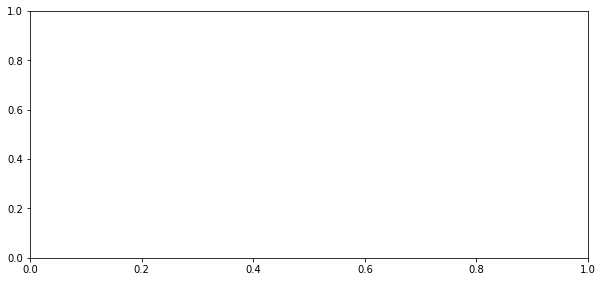

In [26]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(History.history['acc'])  
plt.plot(History.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [45]:
# Predictions (1)
# if you forget to reset the test_generator you will get outputs in a weird order.
validation_generator.reset()
predictions1 = model.predict_generator(validation_generator, steps=nb_validation_samples)

#label with corresponding largest predictied probability
predictions1 = np.argmax(predictions1, axis=1)

print(predictions1)

[8 8 0 ... 0 0 8]


In [105]:
# Predictions (2)
### Load the model weights with the best validation loss.
model.load_weights('weights.best.INCEPTION.all.hdf5')

predictions2 = [np.ma.argmax(model.predict(feature[0]),1) for feature in validation_generator]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions2)==np.argmax(test_targets, axis=1))/len(predictions2)
print('Test accuracy: %.4f%%' % test_accuracy)

predictions2

In [95]:
np.ma.argmax(model.predict(validation_generator.next()[0]),1)

array([8, 0, 8, 8, 8, 0, 8, 8, 0, 8, 0, 0, 0, 8, 8, 8], dtype=int64)

In [34]:
# Predictions (3)

(eval_loss, eval_accuracy) = model.evaluate_generator(validation_generator,steps = batch_size, verbose=1)

print(eval_loss, eval_accuracy)

16/16 [==============================] - 145s 9s/step
2.436826854944229 0.20703125


In [41]:
y_true = np.argmax(test_targets, axis=1)
y_true

array([ 8,  1,  4, ..., 10,  4,  4], dtype=int64)

In [64]:
len(y_true), len(predictions1)

(2003, 2000)

In [66]:
print(classification_report(y_true[:2000], predictions, target_names=labels))

                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00       213
      Cardiomegaly       0.00      0.00      0.00       157
     Consolidation       0.00      0.00      0.00       104
             Edema       0.00      0.00      0.00        47
          Effusion       0.00      0.00      0.00       231
         Emphysema       0.00      0.00      0.00        65
          Fibrosis       0.00      0.00      0.00        76
            Hernia       0.00      0.00      0.00        23
      Infiltration       0.30      1.00      0.46       598
              Mass       0.00      0.00      0.00        69
            Nodule       0.00      0.00      0.00        90
Pleural_Thickening       0.00      0.00      0.00        99
         Pneumonia       0.00      0.00      0.00        24
      Pneumothorax       0.00      0.00      0.00       204

         micro avg       0.30      0.30      0.30      2000
         macro avg       0.02      0.0

C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
